In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter as clock
#from beautifultable import BeautifulTable
np.random.seed(0)

In [2]:
class Kernel:
    def __init__(self, sigma = 0.5, dim = 2):
        self.sigma = sigma
        self.dim = dim
        self.family = [self.linear, self.poly, self.rbf]
    
    def linear(self, x, y):
        return float(x.dot(y.T))
    
    def poly(self, x, y):
        return self.linear(x,y) ** self.dim
    
    def rbf(self, x, y):
        return np.exp(-float(np.linalg.norm(x - y)) ** 2 / (2 * self.sigma ** 2))

In [3]:
class SVM:
    def __init__(self, kernel, C = 1, k_max = 100, tol = 1e-3):
        '''
        kernel: Kernel Transformation function
        C: Regularizer 
        k_max: Maximum update iteration
        tol: KKT tolerance
        '''
        self.kernel = kernel
        self.C = C
        self.k_max = k_max
        self.tol = tol
    
    # Optimization
    
    def fit(self, X, Y):
        '''
        X: Feature values # m*n
        Y: Target values {-1, 1} # m*1
        _alphas: Lagrangian Multipliers # m*1
        b = Bias
        _K: Gram matrix # m*m
        _E:
        
        sv: Support Vector informations
        report: Training report
        '''
        self.X = np.mat(X, dtype = 'float64') 
        if set(Y) != {-1, 1}:
            raise ValueError('Traget values have to be -1 or 1')
        self.Y = np.mat(Y).T      
        self.m, self.n = self.X.shape
        self._alphas = np.mat(np.zeros((self.m, 1))) 
        self.b = 0
        self._K = self._gram_matrix(self.X) 
        self._E = np.mat(-self.Y) # m*1
        
        self.sv = dict()
        self.report = dict()
        self.report['iteration'] = 0
        self.report['time'] = clock()
        return self._sequential_minimal_optimization()
    
    def _sequential_minimal_optimization(self):
        all_traversed, pair_updated = False, 0
        while self.report['iteration'] < self.k_max:
            self.report['iteration'] += 1
            if all_traversed and pair_updated == 0:
                break
            pair_updated = 0
            if not all_traversed:
                for i in range(self.m):
                    pair_updated += self._inner_optimize(i)
                all_traversed = True
            else:
                for i, alpha in enumerate(self._alphas):
                    if 0 < alpha and alpha < self.C:
                        pair_updated += self._inner_optimize(i)
                all_traversed = pair_updated != 0
                
        self._record_support_vectors()
        self.report['time'] = clock() - self.report['time']
        return self.report
    
    def _inner_optimize(self, i):
        alphai, Yi, Ei = self._alphas[i, 0], self.Y[i, 0], self._E[i, 0]
        if self._KKT_check(alphai, Yi, Ei):
            # KKT satisfied, no optimization needed
            return 0
        # select j to have maximun |Ei - Ej|
        j = self._best_j(i)
        alphaj, Yj, Ej = self._alphas[j, 0], self.Y[j, 0], self._E[j, 0]
        # compute boundaries
        l, h = self._compute_bound(alphai, Yi, alphaj, Yj)
        eta = self._K[i, i] + self._K[j, j] - 2.0 * self._K[i, j]
        if l == h or eta == 0:
            return 0
        
        # update alpha j and i
        j_prime = alphaj + Yj * (Ei - Ej) / eta
        self._alphas[j, 0] = h if j_prime > h else l if j_prime < l else j_prime
        j_delta = Yj * (self._alphas[j, 0] - alphaj)
        self._alphas[i, 0] -= Yi * j_delta
        i_delta = Yi * (self._alphas[i, 0] - alphai)
        
        # update b
        prev_b = self.b
        b1 = prev_b - Ei - i_delta * self._K[i, i] - j_delta * self._K[i, j]
        b2 = prev_b - Ej - i_delta * self._K[i, j] - j_delta * self._K[j, j]
        if 0 < self._alphas[i, 0] < self.C:
            self.b = b1
        elif 0 < self._alphas[j, 0] < self.C:
            self.b = b2
        else:
            self.b = (b1 + b2) / 2
            
        # update E
        b_delta = self.b - prev_b
        self._E += ([i_delta, j_delta] * self._K[[i, j]]).T + b_delta
        
        return 1 #if abs(j_delta) > 1e-5 else 0
            
        
    def _KKT_check(self, alpha, y, e):
        return not((alpha < self.C and y * e < -self.tol) or\
                  (alpha > 0 and y * e > self.tol))
    
    def _compute_bound(self, alphai, Yi, alphaj, Yj):
        if Yi == Yj:
            l = max(0, alphai + alphaj - self.C)
            h = min(self.C, alphai + alphaj)
        else:
            l = max(0, alphaj - alphai)
            h = min(self.C, self.C + alphaj - alphai)
        return l, h
    
    def _best_j(self, i):
        '''
        Find the best j such that |Ei - Ej| is the largest, that is:
        if Ei > 0, find the smallest Ej
        else, find the largest Ej
        '''
        indexes, values = [], []
        for k, alpha in enumerate(self._alphas):
            if k != i and 0 < alpha and alpha < self.C:
                indexes.append(k); values.append(self._E[k])
               
        if len(values) == 0: # no best j available, pick any j that is not i
            j = i
            while j == i: j = (self.m - i) // 2; i += 1
            return j
        # maximize |Ei - Ej|
        find = np.argmin if self._E[i] > 0 else np.argmax
        return indexes[find(values)]
        
    def _gram_matrix(self, X):
        '''
        Positive-semidefinite
        '''
        K = np.mat(np.zeros((self.m, self.m)))
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X[:i + 1]):
                K[i, j] = K[j, i] = self.kernel(x_i, x_j)
        return K
    
    def _record_support_vectors(self):
        self.sv['i'] = []
        for i, alpha in enumerate(self._alphas):
            if alpha > 0:
                self.sv['i'].append(i)
        svi = self.sv['i']
        self.sv['X'] = self.X[svi]
        self.sv['Y'] = self.Y[svi]
        self.sv['alphas'] = self._alphas[svi]
    
    # Methods
    
    def predict(self, X):
        if len(self.sv) == 0:
            raise RuntimeError('Untrained SVM. Please train the model first.')
        X = np.mat(X)
        K = np.mat([[self.kernel(x, xi) for xi in self.sv['X']] for x in X])
        y = K * np.multiply(self.sv['alphas'], self.sv['Y']) + self.b
        return np.sign(y)
    
    def error(self, X, Y):
        Y_hat = self.predict(X)
        err = sum([Y_hat[i] != Y[i] for i in range(len(X))]) / len(X)
        self.report['error'] = np.asscalar(err)
        return self.report['error']
    
    def plot(self, title = 'SVM', predict = True, data = True, sv = True):
        _, ax = plt.subplots(figsize = (10, 6))
        if predict:
            self._plot_contours(ax)
        if data:
            self._plot_data(ax)
        if sv:
            self._plot_sv(ax)
        ax.set_ylabel('feature 2')
        ax.set_xlabel('feature 1')
        ax.set_title(title, fontsize = 20)
        plt.show()
    
    def _plot_data(self, ax):
        X = np.asarray(self.X)
        Y = np.asarray(self.Y).flatten()
        ax.scatter(X[:,0], X[:,1], c = Y, cmap=plt.cm.coolwarm, s = 50)
        
    def _plot_contours(self, ax):
        xx, yy = self._meshgrid(self.X[:,0], self.X[:,1])
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = np.asarray(Z).reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha = 0.6)
    
    def _plot_sv(self, ax):
        for i, alpha in enumerate(self._alphas):
            if alpha > 0:
                ax.scatter(self.X[i, 0], self.X[i, 1], color='', edgecolors='k', marker='o', s=150)
    
    def _meshgrid(self, x, y, space = 0.5, h=.05):
        x_min, x_max = x.min() - space, x.max() + space
        y_min, y_max = y.min() - space, y.max() + space
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return xx, yy

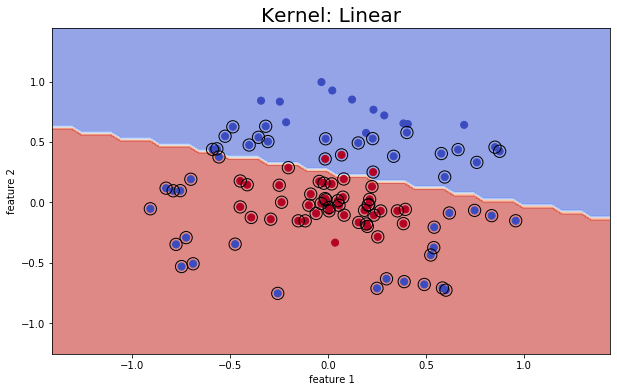

{'iteration': 100, 'time': 0.8521880999999998, 'error': 0.28}


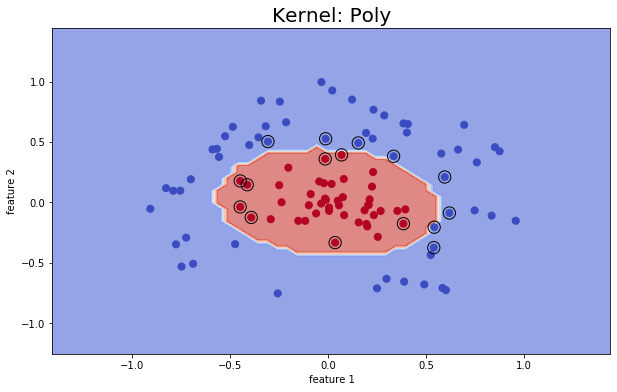

{'iteration': 48, 'time': 0.20124299999999984, 'error': 0.0}


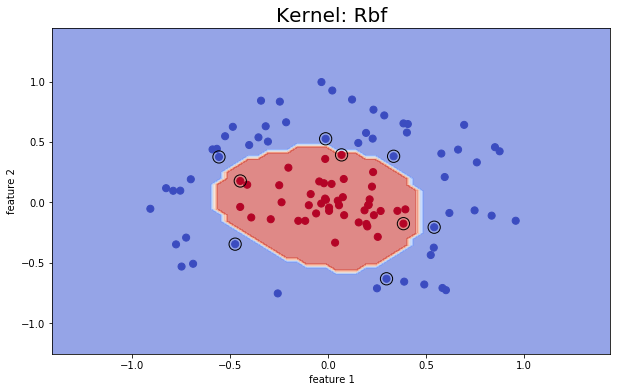

{'iteration': 70, 'time': 0.3530091000000004, 'error': 0.0}


In [4]:
d = np.genfromtxt('nonlinear_data.txt')
X,Y = d[:,:2], d[:,-1]

kernel = Kernel()

for k in kernel.family:
    svm = SVM(k, C = 20)
    svm.fit(X, Y)
    svm.error(X, Y)
    svm.plot(title = 'Kernel: '+k.__name__.title())
    print(svm.report)

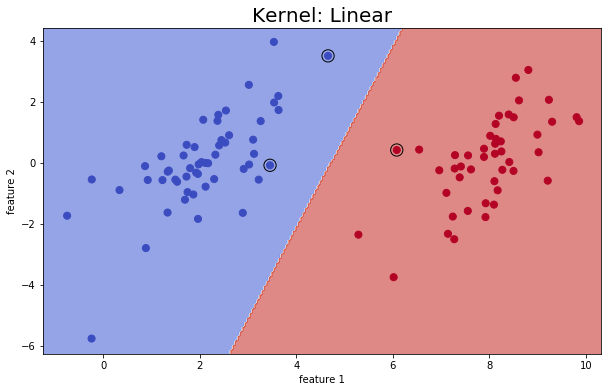

{'iteration': 15, 'time': 0.04960949999999986, 'error': 0.0}


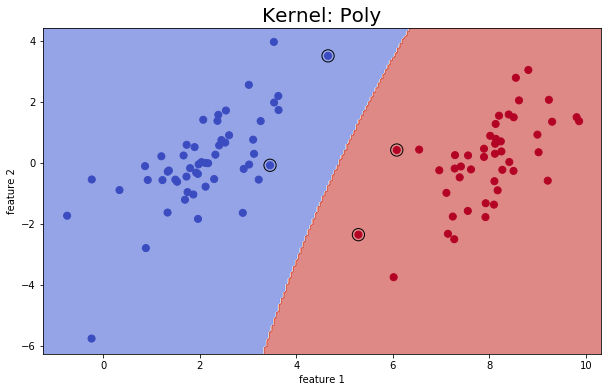

{'iteration': 16, 'time': 0.04550369999999937, 'error': 0.0}


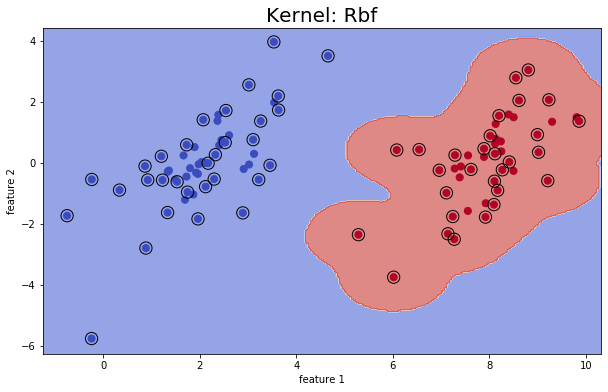

{'iteration': 65, 'time': 1.1871293000000005, 'error': 0.0}


In [5]:
d = np.genfromtxt('linear_data.txt')
X,Y = d[:,:2], d[:,-1]

kernel = Kernel()
for k in kernel.family:
    svm = SVM(k, C = 20)
    svm.fit(X, Y)
    svm.error(X, Y)
    svm.plot(title = 'Kernel: '+k.__name__.title())
    print(svm.report)